<a href="https://colab.research.google.com/github/shani1610/pytorch-for-deep-learning/blob/main/course_exercises/06_pytorch_transfer_learning_exercises.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06. PyTorch Transfer Learning Exercises

Welcome to the 06. PyTorch Transfer Learning exercise template notebook.

There are several questions in this notebook and it's your goal to answer them by writing Python and PyTorch code.

> **Note:** There may be more than one solution to each of the exercises, don't worry too much about the *exact* right answer. Try to write some code that works first and then improve it if you can.

## Resources and solutions

* These exercises/solutions are based on [section 06. PyTorch Transfer Learning](https://www.learnpytorch.io/06_pytorch_transfer_learning/) of the Learn PyTorch for Deep Learning course by Zero to Mastery.

**Solutions:**

Try to complete the code below *before* looking at these.

* See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/ueLolShyFqs).
* See an example [solutions notebook for these exercises on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/solutions/06_pytorch_transfer_learning_exercise_solutions.ipynb).

## 1. Make predictions on the entire test dataset and plot a confusion matrix for the results of our model compared to the truth labels.
* **Note:** You will need to get the dataset and the trained model/retrain the model from notebook 06 to perform predictions.
* Check out [03. PyTorch Computer Vision section 10](https://www.learnpytorch.io/03_pytorch_computer_vision/#10-making-a-confusion-matrix-for-further-prediction-evaluation) for ideas.

In [2]:
# Import required libraries/code
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms, datasets

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

### Get data

In [4]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
        print("Unzipping pizza, steak, sushi data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / "pizza_steak_sushi.zip")

# Setup Dirs
train_dir = image_path / "train"
test_dir = image_path / "test"

Did not find data/pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, sushi data...


### Prepare data

In [5]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [6]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b703c6ba110>,
 ['pizza', 'steak', 'sushi'])

### Get and prepare a pretrained model

In [7]:
# Setup the model with pretrained weights and send it to the target device
model_0 = torchvision.models.efficientnet_b0(pretrained=True).to(device)
#model_0 # uncomment to output (it's very long)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 139MB/s]


In [8]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_0.features.parameters():
    param.requires_grad = False

In [9]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_0.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

### Train model

In [10]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [11]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
model_0_results = engine.train(model=model_0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0895 | train_acc: 0.4414 | test_loss: 0.9202 | test_acc: 0.5085
Epoch: 2 | train_loss: 0.8682 | train_acc: 0.7734 | test_loss: 0.8022 | test_acc: 0.7434
Epoch: 3 | train_loss: 0.7771 | train_acc: 0.7812 | test_loss: 0.7399 | test_acc: 0.7737
Epoch: 4 | train_loss: 0.7249 | train_acc: 0.7422 | test_loss: 0.6472 | test_acc: 0.8864
Epoch: 5 | train_loss: 0.6445 | train_acc: 0.7812 | test_loss: 0.6244 | test_acc: 0.8968
[INFO] Total training time: 10.399 seconds


### Make predictions on the entire test dataset with the model

In [32]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


In [30]:
a = next(iter(test_dataloader))
len(a[0]), len(a[1]), len(a[0][1])

(32, 32, 3)

In [29]:
# TODO
# 1. Get a batch of images and labels from the DataLoader
for img_batch, label_batch in test_dataloader:
  # 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
  img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
  #print(f"Single image shape: {img_single.shape}\n")

  # 3. Perform a forward pass on a single image
  model_0.eval()
  with torch.inference_mode():
      pred = model_0(img_single.to(device))

  # 4. Print out what's happening and convert model logits -> pred probs -> pred label
  # print(f"Output logits:\n{pred}\n")
  # print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
  print(f"Output prediction label:{torch.argmax(torch.softmax(pred, dim=1), dim=1).item()}\n")
  print(f"Actual label:{label_single}")

Output prediction label:0

Actual label:0
Output prediction label:1

Actual label:1
Output prediction label:2

Actual label:2


### Make a confusion matrix with the test preds and the truth labels

Need the following libraries to make a confusion matrix:
* torchmetrics - https://torchmetrics.readthedocs.io/en/stable/
* mlxtend - http://rasbt.github.io/mlxtend/

In [35]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 34.8 MB/s eta 0:00:00
mlxtend version: 0.23.1


In [36]:
# Import mlxtend upgraded version
import mlxtend
print(mlxtend.__version__)
assert int(mlxtend.__version__.split(".")[1]) >= 19 # should be version 0.19.0 or higher

0.23.1


In [33]:
# TODO
# Import tqdm for progress bar
from tqdm.auto import tqdm

# 1. Make predictions with trained model
y_preds = []
model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/3 [00:00<?, ?it/s]

In [41]:
y_pred_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [45]:
targets_tensor = torch.tensor(test_dataloader.dataset.targets)

print(targets_tensor)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2])


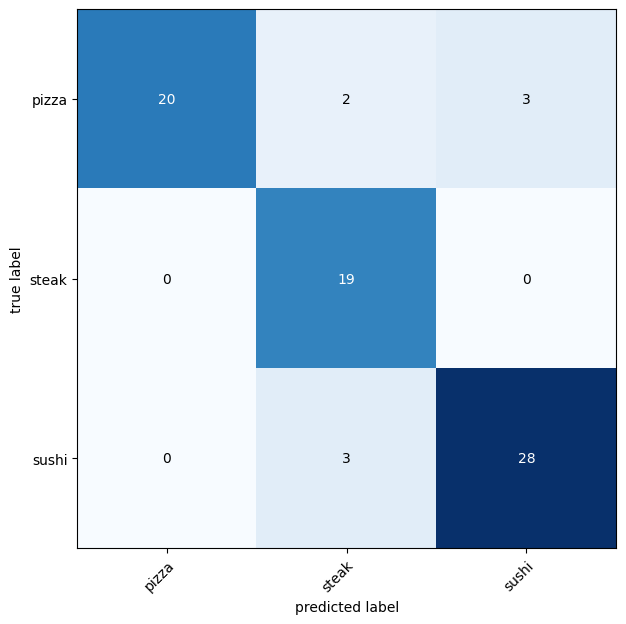

In [46]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_dataloader.dataset.targets))

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

## 2. Get the "most wrong" of the predictions on the test dataset and plot the 5 "most wrong" images. You can do this by:
* Predicting across all of the test dataset, storing the labels and predicted probabilities.
* Sort the predictions by *wrong prediction* and then *descending predicted probabilities*, this will give you the wrong predictions with the *highest* prediction probabilities, in other words, the "most wrong".
* Plot the top 5 "most wrong" images, why do you think the model got these wrong?

You'll want to:
* Create a DataFrame with sample, label, prediction, pred prob
* Sort DataFrame by correct (does label == prediction)
* Sort DataFrame by pred prob (descending)
* Plot the top 5 "most wrong" image predictions

In [67]:
# TODO
# Import tqdm for progress bar
from tqdm.auto import tqdm
import pandas as pd

# 1. Make predictions with trained model
y_pred_probs = []
y_preds = []

# create Data frame
dataframe = []

model_0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_0(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred_prob, _ = torch.softmax(y_logit, dim=1).max(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)

    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
    y_pred_probs.append(y_pred_prob.cpu())

# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)
y_pred_probs_tensor = torch.cat(y_pred_probs)


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70d88da050>Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70d88da050>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()    
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    if w.is_alive():
  File "/usr/lib/

Making predictions:   0%|          | 0/3 [00:02<?, ?it/s]


AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b70d88da050>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1477, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1460, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


In [68]:
y_preds

[tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
         2, 1, 1, 1, 1, 1, 1, 1]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1,
         2, 2, 2, 2, 2, 2, 2, 2]),
 tensor([2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2])]

In [69]:
y_pred_tensor

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2,
        2, 2, 2])

In [70]:
y_pred_tensor.shape

torch.Size([75])

In [71]:
y_pred_probs_tensor

tensor([0.7349, 0.6056, 0.4661, 0.7870, 0.4022, 0.4828, 0.7079, 0.5895, 0.5993,
        0.7782, 0.3841, 0.4088, 0.4351, 0.4259, 0.4743, 0.4269, 0.6850, 0.4504,
        0.6941, 0.7701, 0.4698, 0.4470, 0.6159, 0.5400, 0.4447, 0.9124, 0.6370,
        0.4601, 0.8453, 0.4477, 0.7608, 0.7831, 0.6924, 0.7310, 0.4523, 0.8943,
        0.8424, 0.5342, 0.4057, 0.7878, 0.7858, 0.7825, 0.8590, 0.6751, 0.4496,
        0.4718, 0.5803, 0.6143, 0.7607, 0.8028, 0.5659, 0.3818, 0.4780, 0.5049,
        0.8034, 0.4039, 0.4753, 0.4316, 0.4884, 0.5660, 0.4312, 0.6601, 0.5831,
        0.4869, 0.5095, 0.4432, 0.4640, 0.6263, 0.4139, 0.6240, 0.5470, 0.5397,
        0.5300, 0.4501, 0.7518])

In [72]:
y_pred_probs_tensor.shape

torch.Size([75])

In [76]:
len(test_dataloader.dataset.targets)

75

In [77]:
import pandas as pd

# Convert tensors to NumPy arrays
y_pred_arr = y_pred_tensor.numpy()
y_pred_probs_arr = y_pred_probs_tensor.numpy()

# Create a DataFrame with two columns
df = pd.DataFrame({
    'Label': test_dataloader.dataset.targets,
    'Predicted': y_pred_arr,
    'Probability': y_pred_probs_arr
})

# Display the DataFrame
print(df)

    Label  Predicted  Probability
0       0          0     0.734949
1       0          0     0.605592
2       0          0     0.466127
3       0          0     0.786989
4       0          0     0.402151
..    ...        ...          ...
70      2          1     0.546966
71      2          2     0.539660
72      2          2     0.530035
73      2          2     0.450067
74      2          2     0.751769

[75 rows x 3 columns]


In [79]:

# Filtering the DataFrame
filtered_df = df[df['Label'] != df['Predicted']]

# Display the filtered DataFrame with original indices
print(filtered_df)

    Label  Predicted  Probability
10      0          1     0.384089
12      0          2     0.435139
13      0          1     0.425909
15      0          2     0.426874
24      0          2     0.444701
44      2          1     0.449595
55      2          1     0.403894
70      2          1     0.546966


In [80]:
# Sort by 'Probability' values in descending order
sorted_filtered_df_desc = filtered_df.sort_values(by='Probability', ascending=False)

# Display the sorted DataFrame
print(sorted_filtered_df_desc)

    Label  Predicted  Probability
70      2          1     0.546966
44      2          1     0.449595
24      0          2     0.444701
12      0          2     0.435139
15      0          2     0.426874
13      0          1     0.425909
55      2          1     0.403894
10      0          1     0.384089


In [82]:
# Get the first 5 rows
first_5_rows = sorted_filtered_df_desc.head(5)

# Display the first 5 rows
print(first_5_rows)

    Label  Predicted  Probability
70      2          1     0.546966
44      2          1     0.449595
24      0          2     0.444701
12      0          2     0.435139
15      0          2     0.426874


In [95]:
predicted_value = df.loc[70, 'Predicted']
predicted_value

1

In [87]:
indices = first_5_rows.index.values
indices

array([70, 44, 24, 12, 15])

In [91]:
test_dataloader.dataset.samples[70][0]

'data/pizza_steak_sushi/test/sushi/684266.jpg'

In [97]:
test_dataloader.dataset.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [98]:
classes_dict = test_dataloader.dataset.class_to_idx

In [102]:

# Create a reverse dictionary where values are keys and keys are values
reverse_dict = {v: k for k, v in classes_dict.items()}

# Now you can directly access the key 'pizza' by giving the value 0
key = reverse_dict[0]

# Print the key
print(key)

pizza


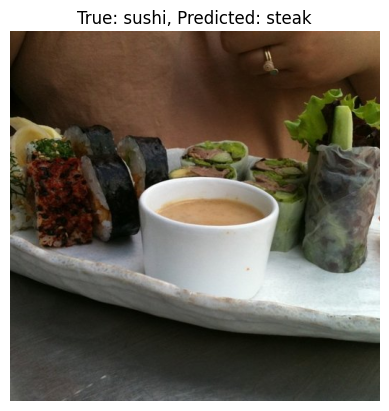

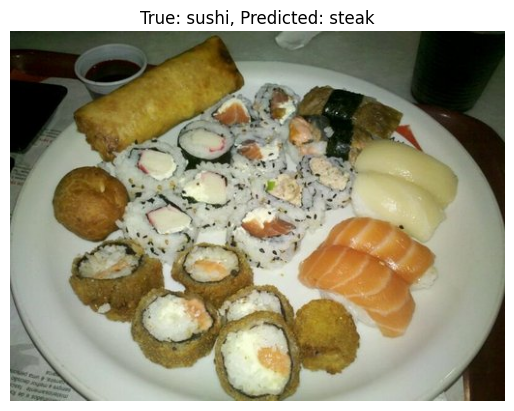

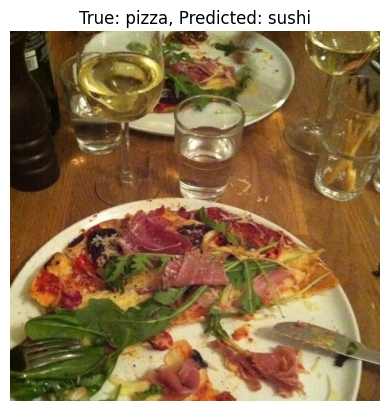

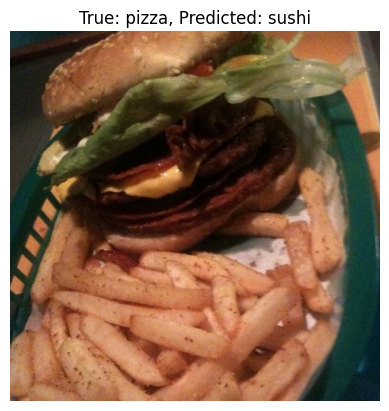

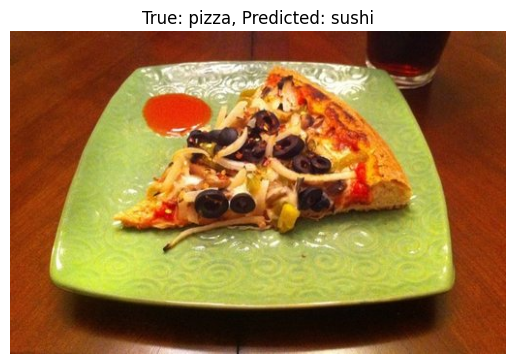

In [103]:
import matplotlib.pyplot as plt
from PIL import Image

for i in indices:
  # Path to the image file
  image_path = test_dataloader.dataset.samples[i][0]

  # Open the image
  image = Image.open(image_path)

  # Display the image
  plt.imshow(image)

  true_lab = reverse_dict[df.loc[i, 'Label']]
  pred_lab = reverse_dict[df.loc[i, 'Predicted']]

  plt.title(f"True: {true_lab}, Predicted: {pred_lab}")

  # Hide axes for a cleaner image display
  plt.axis('off')

  # Show the image
  plt.show()

## 3. Predict on your own image of pizza/steak/sushi - how does the model go? What happens if you predict on an image that isn't pizza/steak/sushi?
* Here you can get an image from a website like http://www.unsplash.com to try it out or you can upload your own.

In [105]:
# TODO: Get an image of pizza/steak/sushi
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "pasta.png"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        # When downloading from GitHub, need to use the "raw" file link
        request = requests.get("https://raw.githubusercontent.com/shani1610/pytorch-for-deep-learning/refs/heads/main/samples/pasta.png")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

In [116]:
# TODO: Get an image of not pizza/steak/sushi
import torchvision

# Read in custom image
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255.

# Print out image data
#print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image shape: torch.Size([4, 571, 540])

Custom image dtype: torch.float32


In [118]:
# many PNG images have an alpha channel in addition to the usual RGB channels.
# Keep only the first 3 channels (RGB)
custom_image = custom_image[:3, :, :]

print(custom_image.shape)  # torch.Size([3, 571, 540])

torch.Size([3, 571, 540])


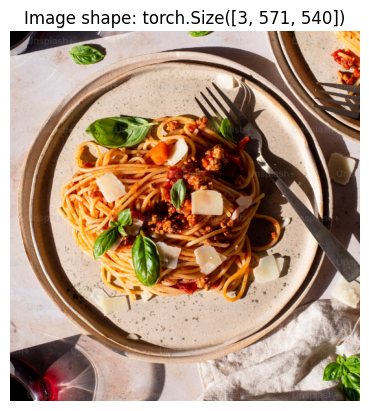

In [119]:
# Plot custom image
plt.imshow(custom_image.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

In [120]:
# Create transform pipleine to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64)),
])

In [121]:
# Transform target image
custom_image_transformed = custom_image_transform(custom_image)


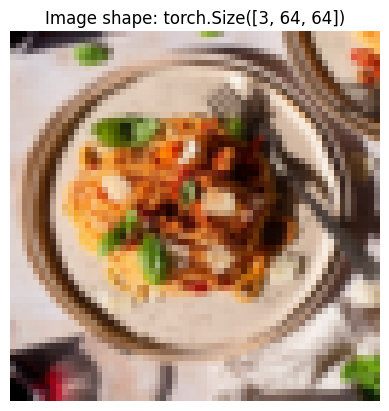

In [122]:
# Plot custom image
plt.imshow(custom_image_transformed.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image_transformed.shape}")
plt.axis(False);

In [123]:
model_0.eval()
with torch.inference_mode():
    # Add an extra dimension to image
    custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

    # Print out different shapes
    print(f"Custom image transformed shape: {custom_image_transformed.shape}")
    print(f"Unsqueezed custom image shape: {custom_image_transformed_with_batch_size.shape}")

    # Make a prediction on image with an extra dimension
    custom_image_pred = model_0(custom_image_transformed.unsqueeze(dim=0).to(device))

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueezed custom image shape: torch.Size([1, 3, 64, 64])


In [125]:
# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.4697, -0.2895,  0.7142]], device='cuda:0')
Prediction probabilities: tensor([[0.3643, 0.1705, 0.4652]], device='cuda:0')
Prediction label: tensor([2], device='cuda:0')


In [126]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred label to CPU, otherwise will error
custom_image_pred_class

'sushi'

## 4. Train the model from section 4  in notebook 06 part 3 for longer (10 epochs should do), what happens to the performance?

* See the model in notebook 06 part 3 for reference: https://www.learnpytorch.io/06_pytorch_transfer_learning/#3-getting-a-pretrained-model

In [127]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model_1 = torchvision.models.efficientnet_b0(weights=weights).to(device)


In [128]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_1.features.parameters():
    param.requires_grad = False

In [129]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_1.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [130]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.001)

In [131]:
# TODO: Train the model for 10 epochs
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model_1,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0563 | train_acc: 0.4375 | test_loss: 0.8431 | test_acc: 0.6913
Epoch: 2 | train_loss: 0.8335 | train_acc: 0.8047 | test_loss: 0.7388 | test_acc: 0.8362
Epoch: 3 | train_loss: 0.7625 | train_acc: 0.8320 | test_loss: 0.6771 | test_acc: 0.8864
Epoch: 4 | train_loss: 0.7156 | train_acc: 0.7500 | test_loss: 0.6066 | test_acc: 0.9072
Epoch: 5 | train_loss: 0.6320 | train_acc: 0.7891 | test_loss: 0.5937 | test_acc: 0.8968
Epoch: 6 | train_loss: 0.5709 | train_acc: 0.7812 | test_loss: 0.5348 | test_acc: 0.8968
Epoch: 7 | train_loss: 0.5171 | train_acc: 0.9336 | test_loss: 0.5059 | test_acc: 0.9072
Epoch: 8 | train_loss: 0.5363 | train_acc: 0.7969 | test_loss: 0.5083 | test_acc: 0.8968
Epoch: 9 | train_loss: 0.5676 | train_acc: 0.7930 | test_loss: 0.4744 | test_acc: 0.9280
Epoch: 10 | train_loss: 0.4955 | train_acc: 0.8008 | test_loss: 0.3995 | test_acc: 0.8655
[INFO] Total training time: 19.906 seconds


[INFO] Couldn't find helper_functions.py, downloading...


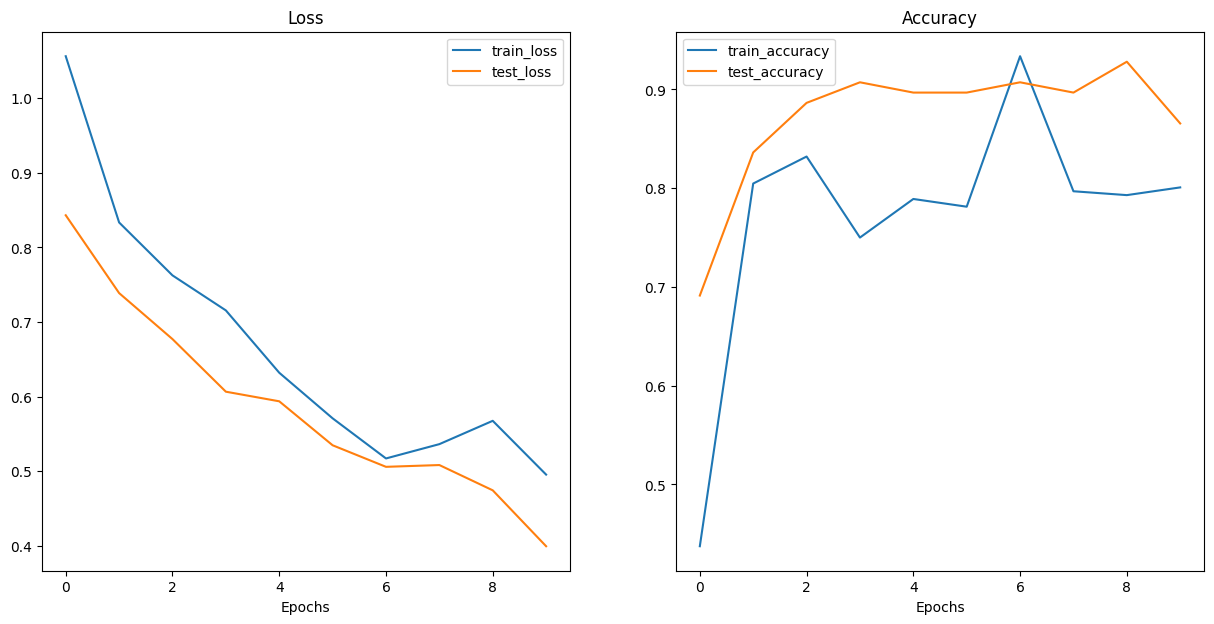

In [132]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)

with 5 epochs we got:

Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561

with 10 epochs we got:

Epoch: 10 | train_loss: 0.4955 | train_acc: 0.8008 | test_loss: 0.3995 | test_acc: 0.8655

better

## 5. Train the model from section 4 above with more data, say 20% of the images from Food101 of Pizza, Steak and Sushi images.
* You can find the [20% Pizza, Steak, Sushi dataset](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip) on the course GitHub. It was created with the notebook [`extras/04_custom_data_creation.ipynb`](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb).


### Get 20% data

In [134]:
import os
import requests
import zipfile

from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"
image_data_zip_path = "pizza_steak_sushi_20_percent.zip"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

    # Download pizza, steak, sushi data
    with open(data_path / image_data_zip_path, "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
        print("Downloading pizza, steak, sushi data...")
        f.write(request.content)

    # Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / image_data_zip_path, "r") as zip_ref:
        print("Unzipping pizza, steak, sushi 20% data...")
        zip_ref.extractall(image_path)

    # Remove .zip file
    os.remove(data_path / image_data_zip_path)

# Setup Dirs
train_dir_20_percent = image_path / "train"
test_dir_20_percent = image_path / "test"

train_dir_20_percent, test_dir_20_percent

Did not find data/pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


(PosixPath('data/pizza_steak_sushi_20_percent/train'),
 PosixPath('data/pizza_steak_sushi_20_percent/test'))

### Create DataLoaders

In [135]:
# Create a transforms pipeline
simple_transform = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(), # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

In [136]:
# Create training and testing DataLoader's as well as get a list of class names
train_dataloader_20_percent, test_dataloader_20_percent, class_names = data_setup.create_dataloaders(train_dir=train_dir_20_percent,
                                                                                                     test_dir=test_dir_20_percent,
                                                                                                     transform=simple_transform, # resize, convert images to between 0 & 1 and normalize them
                                                                                                     batch_size=32) # set mini-batch size to 32

train_dataloader_20_percent, test_dataloader_20_percent, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b70326814e0>,
 ['pizza', 'steak', 'sushi'])

### Get a pretrained model

In [137]:
# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
model_2 = torchvision.models.efficientnet_b0(weights=weights).to(device)

In [138]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_2.features.parameters():
    param.requires_grad = False

In [139]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_2.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [140]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)

In [141]:
# TODO: Train the model for 10 epochs
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results_2 = engine.train(model=model_2,
                       train_dataloader=train_dataloader_20_percent,
                       test_dataloader=test_dataloader_20_percent,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9368 | train_acc: 0.6167 | test_loss: 0.6435 | test_acc: 0.8915
Epoch: 2 | train_loss: 0.6728 | train_acc: 0.8521 | test_loss: 0.5228 | test_acc: 0.8761
Epoch: 3 | train_loss: 0.5706 | train_acc: 0.8396 | test_loss: 0.4465 | test_acc: 0.9068
Epoch: 4 | train_loss: 0.4452 | train_acc: 0.8896 | test_loss: 0.4058 | test_acc: 0.9034
Epoch: 5 | train_loss: 0.4341 | train_acc: 0.8875 | test_loss: 0.3774 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.4146 | train_acc: 0.8438 | test_loss: 0.3483 | test_acc: 0.9222
Epoch: 7 | train_loss: 0.4158 | train_acc: 0.8417 | test_loss: 0.3134 | test_acc: 0.9131
Epoch: 8 | train_loss: 0.3950 | train_acc: 0.8521 | test_loss: 0.3177 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.3208 | train_acc: 0.8917 | test_loss: 0.3070 | test_acc: 0.8977
Epoch: 10 | train_loss: 0.3377 | train_acc: 0.8979 | test_loss: 0.2710 | test_acc: 0.9102
[INFO] Total training time: 40.617 seconds


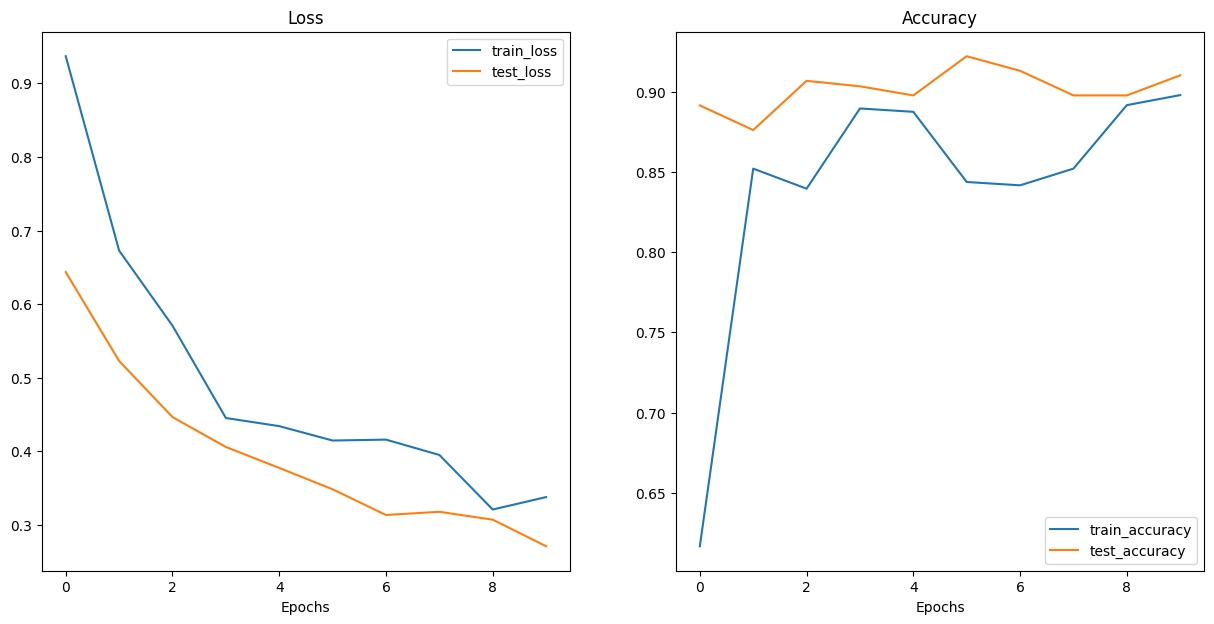

In [142]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results_2)

now we got 0.91 test accuracy!!

Epoch: 10 | train_loss: 0.3377 | train_acc: 0.8979 | test_loss: 0.2710 | test_acc: 0.9102


## 6. Try a different model from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) on the Pizza, Steak, Sushi data, how does this model perform?
* You'll have to change the size of the classifier layer to suit our problem.
* You may want to try an EfficientNet with a higher number than our B0, perhaps `torchvision.models.efficientnet_b2()`?
  * **Note:** Depending on the model you use you will have to prepare/transform the data in a certain way.

In [143]:
# TODO

# NEW: Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT # .DEFAULT = best available weights
model_3 = torchvision.models.efficientnet_b2(weights=weights).to(device)


Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 169MB/s]


In [150]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms


ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [151]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                               batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7b7033e7a350>,
 ['pizza', 'steak', 'sushi'])

In [145]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model_3,
        input_size=(32, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1408, 7, 7]     --                   True
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   True
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   864                  True
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   64                   True
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 16, 112

In [152]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model_3.features.parameters():
    param.requires_grad = False

In [156]:
# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model_3.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1408,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [157]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001)

In [158]:
# TODO: Train the model for 10 epochs
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 10

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model_3,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=NUM_EPOCHS,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0529 | train_acc: 0.4062 | test_loss: 0.9022 | test_acc: 0.6316
Epoch: 2 | train_loss: 0.8297 | train_acc: 0.8711 | test_loss: 0.8101 | test_acc: 0.8977
Epoch: 3 | train_loss: 0.7399 | train_acc: 0.8398 | test_loss: 0.7402 | test_acc: 0.8873
Epoch: 4 | train_loss: 0.7065 | train_acc: 0.7656 | test_loss: 0.6346 | test_acc: 0.8977
Epoch: 5 | train_loss: 0.6377 | train_acc: 0.8164 | test_loss: 0.6181 | test_acc: 0.8977
Epoch: 6 | train_loss: 0.5339 | train_acc: 0.9531 | test_loss: 0.5588 | test_acc: 0.9081
Epoch: 7 | train_loss: 0.4896 | train_acc: 0.9609 | test_loss: 0.5380 | test_acc: 0.9081
Epoch: 8 | train_loss: 0.5463 | train_acc: 0.7969 | test_loss: 0.5444 | test_acc: 0.8977
Epoch: 9 | train_loss: 0.4950 | train_acc: 0.8281 | test_loss: 0.5177 | test_acc: 0.9081
Epoch: 10 | train_loss: 0.4716 | train_acc: 0.8398 | test_loss: 0.4484 | test_acc: 0.8864
[INFO] Total training time: 33.095 seconds


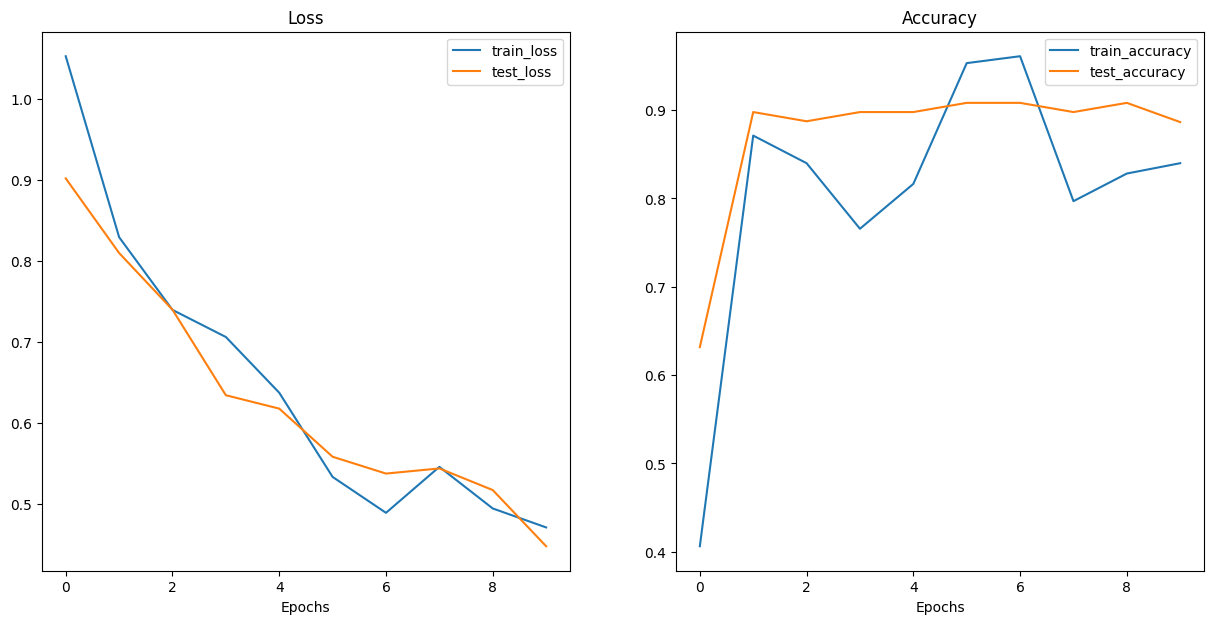

In [159]:
# Get the plot_loss_curves() function from helper_functions.py, download the file if we don't have it
try:
    from helper_functions import plot_loss_curves
except:
    print("[INFO] Couldn't find helper_functions.py, downloading...")
    with open("helper_functions.py", "wb") as f:
        import requests
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
        f.write(request.content)
    from helper_functions import plot_loss_curves

# Plot the loss curves of our model
plot_loss_curves(results)